# Source localization using `NIH CTF` data

In [1]:
%matplotlib qt
from mayavi import mlab

import os.path as op
import mne
data_path = '/Users/larsoner/Desktop/NIH'
subject = 'DLRMCDEH'
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

## Load the raw data and epoch it

In [2]:
# fname_raw = op.join(data_path, 'DLRMCDEH_asvef_20180917_02-f.ds')
# raw = mne.io.read_raw_ctf(fname_raw, preload=True)
# raw.filter(None, 40.)
# events = mne.find_events(raw, 'UPPT001')
# assert raw.info['sfreq'] == 1200
# epochs = mne.Epochs(raw, events, decim=6, preload=True)
fname_epochs = op.join(data_path, '%s-epo.fif' % subject)
# epochs.save(fname_epochs)
epochs = mne.read_epochs(fname_epochs)
print(epochs)

<EpochsFIF  |   400 events (all good), -0.2 - 0.5 sec, baseline [-0.2, 0], ~166.2 MB, data loaded,
 '1': 103
 '2': 100
 '3': 90
 '4': 107>


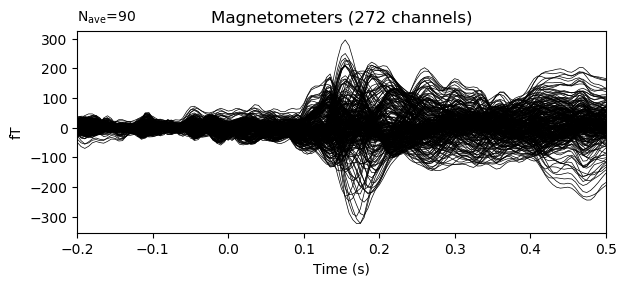

In [3]:
evoked_l = epochs['3'].average()
evoked_l.plot()

## Compute a covariance

In [4]:
fname_cov = op.join(data_path, '%s-cov.fif' % subject)
# cov = mne.compute_covariance(epochs, tmax=0., method='shrunk', verbose=True)
# mne.write_cov(fname_cov, cov)
cov = mne.read_cov(fname_cov)
print(cov)

<Covariance  |  size : 272 x 272, n_samples : 16400, data : [[ 1.32483227e-26  1.25678768e-26  1.10994243e-26 ... -1.84070173e-27
  -1.12644869e-27 -3.90277266e-27]
 [ 1.25678768e-26  1.51377867e-26  1.50927239e-26 ... -2.10372021e-27
  -1.33065057e-27 -3.91773920e-27]
 [ 1.10994243e-26  1.50927239e-26  1.83696260e-26 ... -2.58354438e-27
  -1.73835984e-27 -4.30879672e-27]
 ...
 [-1.84070173e-27 -2.10372021e-27 -2.58354438e-27 ...  8.12624256e-27
   4.30558864e-27  5.52693975e-27]
 [-1.12644869e-27 -1.33065057e-27 -1.73835984e-27 ...  4.30558864e-27
   6.00821830e-27  8.06358019e-28]
 [-3.90277266e-27 -3.91773920e-27 -4.30879672e-27 ...  5.52693975e-27
   8.06358019e-28  2.06449743e-26]]>


### Look at whitened data

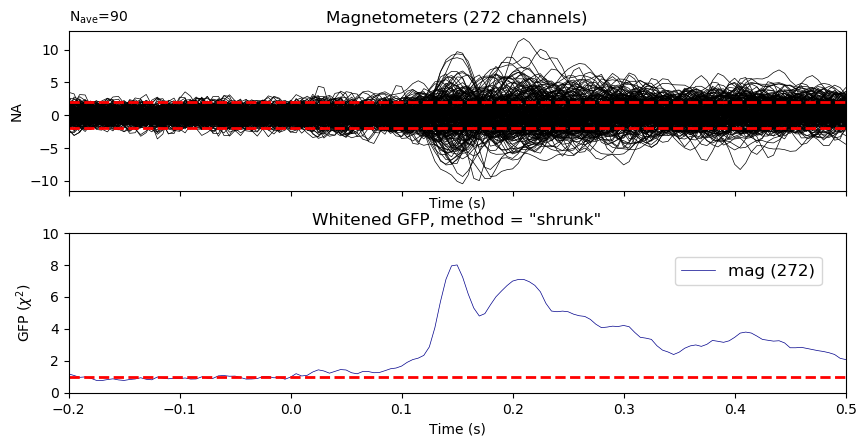

In [5]:
evoked_l.plot_white(cov)

## Go from sensor to source space

### Make a *head<->MRI transformation matrix*

```Console
$ cd ~/Desktop/NIH
$ mne coreg -d subjects -s DLRMCDEH --fif DLRMCDEH-epo.fif
```

### Make a *conductor model*

In [6]:
fname_model = op.join(bem_dir, '%s-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-bem-sol.fif' % subject)
# print('Constructing BEM')
# model = mne.make_bem_model(subject, conductivity=(0.3,),
#                            subjects_dir=subjects_dir, verbose=True
# mne.write_bem_surfaces(fname_model, model)
# bem = mne.make_bem_solution(model, verbose=True)
# mne.write_bem_solution(fname_bem, bem)
bem = mne.read_bem_solution(fname_bem)

### Make a *source space*

In [7]:
fname_src = op.join(bem_dir, '%s-oct-6-src.fif' % subject)
# cortical source space:
# src = mne.setup_source_space(subject, add_dist=False,  # just for speed!
#                              subjects_dir=subjects_dir, verbose=True)
# mne.write_source_spaces(fname_src, src)
src = mne.read_source_spaces(fname_src)

In [8]:
trans = mne.read_trans(op.join(data_path, '%s-trans.fif' % subject))
print(trans)

<Transform  |  head->MRI (surface RAS)>
[[ 0.99935991  0.00912783  0.03459065  0.00652315]
 [ 0.00257846  0.94600946 -0.32412872  0.00553108]
 [-0.03568168  0.32401043  0.94538039 -0.02476563]
 [ 0.          0.          0.          1.        ]]


In [9]:
mne.viz.plot_alignment(evoked_l.info, bem=bem, trans=trans,
                       coord_frame='meg', show_axes=True,
                       meg='sensors',
                       dig=True, surfaces=('inner_skull',))

## Combine these to make a forward model

In [10]:
fname_fwd = op.join(data_path, '%s-fwd.fif' % subject)
# fwd = mne.make_forward_solution(epochs.info, trans, src, bem,
#                                 mindist=5., verbose=True)
# mne.write_forward_solution(fname_fwd, fwd)
fwd = mne.read_forward_solution(fname_fwd)

## Compute a dipole fit

In [11]:
t = evoked_l.get_peak('mag')[1]
print(t)

0.17


In [12]:
dip = mne.fit_dipole(evoked_l.copy().crop(t, t),
                     cov, bem, trans, verbose=True)[0]

BEM               : <ConductorModel  |  BEM (1 layer)>
MRI transform     : instance of Transform
Head origin       :   -3.2   -1.6   58.9 mm rad =   74.8 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using standard MEG coil definitions.

Coordinate transformation: MRI (surface RAS) -> head
     0.999360  0.002578 -0.035682      -7.42 mm
     0.009128  0.946009  0.324010       2.73 mm
     0.034591 -0.324129  0.945380      24.98 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     0.999472 -0.013757 -0.029439      -6.59 mm
     0.021334  0.961158  0.275173       6.15 mm
     0.024510 -0.275656  0.960944      64.12 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read 272 MEG channels from info
Read  28 MEG compensation channels from info
84 coil definitions read
Coordinate transformation: MEG device -> head
     0.999472 -0.013757 -0.029439      -6.59 mm
     0.021334  0.961

In [13]:
dip

<Dipole  |  n_times : 1, tmin : 0.170, tmax : 0.170>

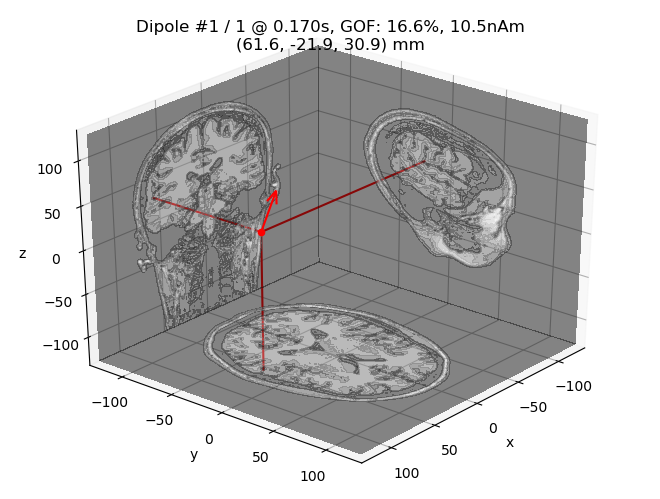

In [14]:
dip.plot_locations(trans, subject, subjects_dir=subjects_dir)

## Compute a MNE solution (dSPM)

In [15]:
inv = mne.minimum_norm.make_inverse_operator(evoked_l.info, fwd, cov,
                                             loose=0.2, depth=0.8,
                                             verbose=True)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 272 channels
Creating the depth weighting matrix...
    272 magnetometer or axial gradiometer channels
    limit = 8079/8195 = 10.039128
    scale = 4.35642e-11 exp = 0.8
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing data rank from covariance with rank=None
    Using tolerance 1.1e-13 (2.2e-16 eps * 272 dim * 1.9  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 p

In [16]:
print(inv)

<InverseOperator | MEG channels: 272 | EEG channels: 0 | Source space: surface with 8195 sources | Source orientation: Free>


In [17]:
stc = mne.minimum_norm.apply_inverse(evoked_l, inv, verbose=True)

Removing 5 compensators from info because not all compensation channels were picked.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 90
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 272 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "3"...
    Picked 272 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  73.1% variance
    Combining the current components...
    dSPM...
[done]


In [18]:
print(stc)

<SourceEstimate  |  8195 vertices, subject : DLRMCDEH, tmin : -200.0 (ms), tmax : 500.0 (ms), tstep : 5.0 (ms), data shape : (8195, 141)>


In [19]:
kwargs = dict(views=['lat', 'med'], hemi='split',
              smoothing_steps=5, subjects_dir=subjects_dir)
brain = stc.copy().crop(t, t).plot(**kwargs)

## Compute LCMV

In [20]:
fwd_fixed = mne.convert_forward_solution(fwd, force_fixed=True)
data_cov = mne.compute_covariance(epochs['3'], tmin=0.04, tmax=0.25,
                                  method='shrunk')
filters = mne.beamformer.make_lcmv(evoked_l.info, fwd_fixed, data_cov,
                                   noise_cov=cov, verbose=True)

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Computing data rank from covariance with rank='info'
    MAG: rank 272 after 0 projectors applied to 272 channels
Computing data rank from covariance with rank='info'
    MAG: rank 272 after 0 projectors applied to 272 channels
Making LCMV beamformer with rank {'mag': 272}
Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Selected 272 channels
Whitening the forward solution.
Computing data rank from covariance with rank={'mag': 272}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.


In [21]:
stc = mne.beamformer.apply_lcmv(evoked_l, filters)
brain = abs(stc).copy().crop(t, t).plot(**kwargs)

## Compute sparse solution

In [22]:
from mne.inverse_sparse import mixed_norm
alpha = 40  # regularization parameter between 0 and 100 (100 is high)
n_mxne_iter = 10  # if > 1 use L0.5/L2 reweighted mixed norm solver

# Compute (ir)MxNE inverse solution with dipole output
stc = mixed_norm(
    evoked_l.copy().crop(0, 0.3),
    fwd, cov, alpha, debias=True,
    n_mxne_iter=n_mxne_iter, verbose=True)
mne.viz.plot_sparse_source_estimates(fwd['src'], stc)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 272 channels
Creating the depth weighting matrix...
Applying loose dipole orientations. Loose value of 0.2.
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing data rank from covariance with rank=None
    Using tolerance 1.1e-13 (2.2e-16 eps * 272 dim * 1.9  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting sourc